Starting softmax regression


C:\GitRepos\IntroToML\venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\stav5\AppData\Local\Temp\ipykernel_32200\1785684768.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train.insert(0, 'Bias', 1)
C:\Users\stav5\AppData\Local\Temp\ipykernel_32200\1785684768.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

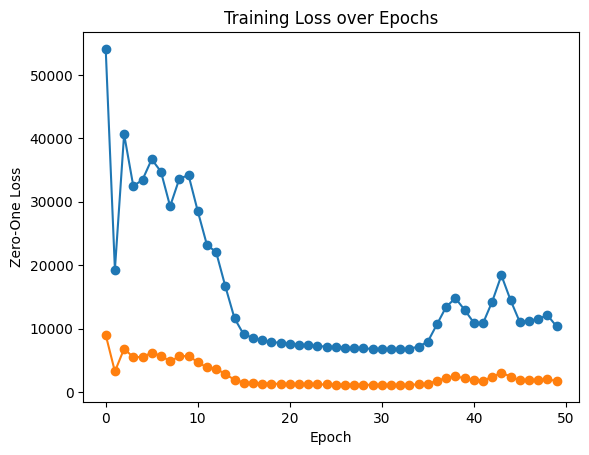

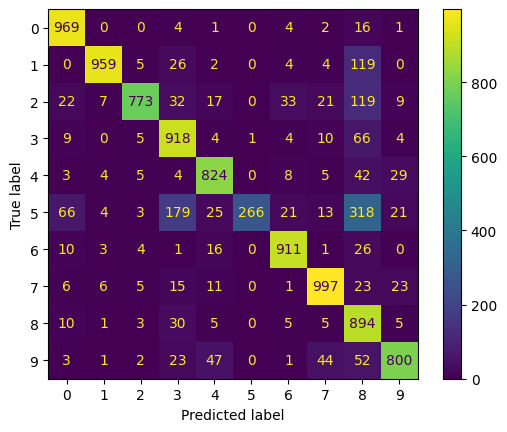

accuracy: 0.8311
Sensitivity for each class:
Class 0: 0.97
Class 1: 0.86
Class 2: 0.75
Class 3: 0.90
Class 4: 0.89
Class 5: 0.29
Class 6: 0.94
Class 7: 0.92
Class 8: 0.93
Class 9: 0.82


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from softmax_classifier import train, test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

def test(x, w_multi):
    result_matrix = x.dot(w_multi.T)
    x["preds"] = result_matrix.apply(np.argmax, axis=1)


def train(x_train, y_train, x_test, y_test, learning_rate, max_error, max_iterations):
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)
    y_train_onehot = pd.get_dummies(y_train_int).astype(int)

    # init weights vector for all classes
    w = np.random.uniform(0, 0, (10, 785))
    loss_per_epoch = []
    loss_test_over_epoch = []

    for i in range(max_iterations):
        gradient = calc_gradient(x_train, y_train_onehot, w)
        error = get_errors(x_train, y_train_int, w)
        test_error = get_errors(x_test, y_test_int, w)
        loss_per_epoch.append(error)
        loss_test_over_epoch.append(test_error)

        if np.linalg.norm(gradient) < max_error:
            return w

        w = w - learning_rate * gradient

    return w, loss_per_epoch, loss_test_over_epoch


def calc_gradient(x_train, y_train, w):
    # h(x)
    wx = np.dot(x_train, w.T)
    softmax_probs = softmax(wx)

    N = x_train.shape[0]
    gradient = np.dot((y_train - softmax_probs).T, x_train) / -N

    return gradient


def softmax(s):
    # subtract by max to protect from overflow
    exp_x = np.exp(s - np.max(s, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


def get_errors(x_train, y_train, w):
    all_preds = x_train.dot(w.T).apply(np.argmax, axis=1)
    errors = (all_preds != y_train)
    return np.sum(errors)


def run_softmax():
    print(f'Starting softmax regression')

    # Fetch MNIST dataset
    mnist = fetch_openml('mnist_784')

    # Extract features (x) and labels (y)
    x, y = mnist.data, mnist.target

    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000)

    # Add bias
    x_train.insert(0, 'Bias', 1)
    x_test.insert(0, 'Bias', 1)

    w, loss_over_epoch, test_loss_over_epoch = train(x_train, y_train, x_test, y_test, 0.01, 0.1, 50)
    test(x_test, w)
    actual = y_test.astype(int)
    preds = x_test["preds"]

    # Plot the loss graph
    plt.plot(range(50), loss_over_epoch, test_loss_over_epoch, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Zero-One Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    # generate confusion matrix
    test_cmatrix = confusion_matrix(actual, preds)
    test_display = ConfusionMatrixDisplay(test_cmatrix)
    test_display.plot()
    plt.savefig('confusion_matrix.png')

    plt.show()

    print(f'accuracy: {accuracy_score(actual, preds)}')

    sensitivity_per_class = []

    for i in range(10):
        true_positives = test_cmatrix[i, i]
        false_negatives = sum(test_cmatrix[i, :]) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives)
        sensitivity_per_class.append(sensitivity)

    print("Sensitivity for each class:")
    for i, sensitivity in enumerate(sensitivity_per_class):
        print(f"Class {i}: {sensitivity:.2f}")

run_softmax()